In [5]:
import numpy as np
import numpy.ma as ma
import os
from datetime import datetime, timedelta
import json
import osgeo.gdal as gdal
import osgeo.ogr as ogr
import osgeo.osr as osr
from osgeo.gdalconst import *
from pyproj import Proj, transform
import fiona
import warnings
from collections import OrderedDict
import time

In [6]:
class Patch:
    def __init__(self, *args, **kwargs):
        """
        Constructor of the class
        @params:
            args            - Optional  : list of parameters
            kwargs          - Optional  : list of parameters in key value format
        """
        if 'json' in kwargs:
            path_json = kwargs.get('json')
            if os.path.exists(path_json):
                with open(path_json) as f:
                    data = json.load(f)
                    self.x = int(path_json.split('/')[-1].split('_')[1])
                    self.y = int(path_json.split('/')[-1].split('_')[2].split('.')[0])
                    self.tile = str(path_json.split('/')[-1].split('_')[0])
                    self.s1_dates = Patch.to_date(data['corresponding_s1'].split(';'), is_filename=True)
                    self.s2_dates = Patch.to_date(data['corresponding_s2'].split(';'), is_filename=True)
                    self.projection = str(data['projection'])
                    self.labels = data['labels'].split(';')
            else:
                raise Exception("Json path does\'t exists !!'")
        else:
            self.x = int(kwargs.get('x', None))
            self.y = int(kwargs.get('y', None))
            self.tile = kwargs.get('tile', None)
            self.s2_dates = kwargs.get('s2_dates', None)
            self.s1_dates = kwargs.get('s1_dates', None)
            self.projection = kwargs.get('projection', None)
            self.labels = kwargs.get('labels', None)

        
    def reconstruct_filename(self, data='gr', dates_to_keep=None, date_format='%Y%m%d'):
        """
        Reconstruct the filename(s) of ground reference (gr) patch, Sentinel-2 (s2) patche(s) or Sentinel-1 (s1) patches.
        @params:
            data            - Required  : data to reconstruct filenames ('gr' for ground reference, 's2' for Sentinel-2, 's1' for Sentinel-1)
            dates_to_keep   - Required  : Dates to keep to generate filenames (available for s2 and s1)
            date_format     - Required  : format of the dates in dates_to_keep (default : %Y%m%d)
        """
        assert data == 'gr' or data == 's2' or data == 's1'
        
        template_s1 = '{tile}_{date}_S1_{x}_{y}.tif'
        template_s2 = '{tile}_{date}_S2_{x}_{y}.tif'
        template_gr = '{tile}_GR_{x}_{y}.tif'
        
        if data == 'gr':
            return template_gr.format(tile=str(self.tile), x=str(self.x), y=str(self.y))
        elif data == 's2':
            res = []
            if dates_to_keep is not None:
                dates_datetime = Patch.to_date(dates_to_keep, date_format=date_format)
                
                for d_keep in dates_datetime:
                    for d in self.s2_dates:
                        if (d.day == d_keep.day) and (d.month == d_keep.month) and (d.year == d_keep.year):
                            res.append(template_s2.format(tile=str(self.tile), date=d.strftime(date_format), x=str(self.x), y=str(self.y)))
                
                return res
            else:
                for d in self.s2_dates:
                    res.append(template_s2.format(tile=str(self.tile), date=d.strftime(date_format), x=str(self.x), y=str(self.y)))
                    
                return res
        elif data == 's1':
            res = []
            if dates_to_keep is not None:
                dates_datetime = Patch.to_date(dates_to_keep, date_format=date_format)
                
                for d_keep in dates_datetime:
                    for d in self.s1_dates:
                        if (d.day == d_keep.day) and (d.month == d_keep.month) and (d.year == d_keep.year):
                            res.append(template_s1.format(tile=str(self.tile), date=d.strftime(date_format), x=str(self.x), y=str(self.y)))
                
                return res
            else:
                for d in self.s1_dates:
                    res.append(template_s1.format(tile=str(self.tile), date=d.strftime(date_format), x=str(self.x), y=str(self.y)))
                
                return res
        
    
    def matching_periods(self, periods, nb_data_per_period=1, period_format='%Y%m%d', is_s2=True):
        """
        Check if the patch have nb_data_per_period for each period in periods (list of a list)
        @params:
            periods               - Required  : list of period in period_format format (This is a list of a list with date1 to date2)
            nb_data_per_period    - Required  : number of data needed per period
            period_format         - Required  : date format, default %Y%m%d
            is_s2                 - Required  : True your want to perform on S2 patches, False if you want to perform on S1 patches
        """
        res = True
        sat_dates = None
        
        if is_s2:
            sat_dates = self.s2_dates
        else:
            sat_dates = self.s1_dates
        
        for period in periods:
            period = Patch.to_date(period, date_format=period_format)
            
            assert len(period) == 2
            assert period[0] < period[1]
            
            in_current_period = False
            nb_current_period = 0
            
            for date in sat_dates:
                if period[0] <= date <= period[1]:
                    in_current_period = True
                    nb_current_period += 1
            
            if (not in_current_period) or (nb_current_period < nb_data_per_period):
                return False
        
        return res
    
    
    def has_nb_dates(self, nb_dates, is_s2=True):
        """
        Check if the patch has a certain number (nb_data patchs) of dates 
        @params:
            nb_dates            - Required  : list of dates in month format
            is_s2               - Required  : directory containing Sentinel-2 images
        """
        has_dates = False
        
        if is_s2:
            if len(self.s2_dates) >= nb_dates:
                has_dates = True
        else:
            if len(self.s1_dates) >= nb_dates:
                has_dates = True
                
        return has_dates
    
    
    def has_matching_monthes(self, dates, nb_data_per_month=1, date_format='%Y%m', is_s2=True):
        """
        Check if the patch has a certain number (nb_data_per_month patchs) for each months (dates) for S1 or S2.
        @params:
            dates               - Required  : list of dates in month format
            nb_data_per_month   - Required  : number of data needed per month
            date_format         - Required  : date format, default %Y%m to get only months
            is_s2               - Required  : True your want to perform on S2 patches, False if you want to perform on S1 patches
        """
        res = True
        
        dates_to_search = Patch.to_date(dates, date_format=date_format)
        _tmp_dates = {}
        sat_dates = None
        
        if is_s2:
            sat_dates = self.s2_dates
        else:
            sat_dates = self.s1_dates

        for date in sat_dates:
            new_date = datetime.strptime(str(date.year) + str(date.month), '%Y%m')
            if new_date not in _tmp_dates:
                _tmp_dates[new_date] = 1
            else:
                 _tmp_dates[new_date] += 1

        for d_to_search in dates_to_search:
            if d_to_search not in _tmp_dates:
                return False
            else:
                if _tmp_dates[d_to_search] < nb_data_per_month:
                    return False

        return res
    
    
    def has_days_gap_s2(self, dates, date_format='%Y%m', days_gap=20):
        """
        Check if there is at least days_gap between each S2 image in each month.
        @params:
            dates               - Required  : list of dates in month format
            date_format         - Required  : date format, default %Y%m to get only months
            days_gap            - Required  : minimum gap between two monthes
        """
        dates_search = sorted(Patch.to_date(dates, date_format=date_format))
        sorted_s2 = sorted(self.s2_dates)
        corresponding_s2_dates = {}
        
        for s2_d in sorted_s2:
            for search_d in dates_search:
                if s2_d.month == search_d.month:
                    if search_d.month in corresponding_s2_dates:
                        corresponding_s2_dates[search_d.month].append(s2_d)
                    else:
                        corresponding_s2_dates[search_d.month] = [s2_d]
                    
        corresponding_s2_dates = OrderedDict(sorted(corresponding_s2_dates.items()))
        if len(corresponding_s2_dates.keys()) < len(dates_search):
            return None, False
        
        _previous_item  = None
        output_dates = []
        for key, value in corresponding_s2_dates.items():
            if _previous_item is None:     
                _previous_item = value
            else:
                _tmp = []
                for e in _previous_item:
                    for f in value:
                        delta = f - e
                        
                        if delta.days >= days_gap:
                            _tmp.append(f)
                            
                    if len(_tmp) >= 1:
                        output_dates.append(e)
                        break
                
                _previous_item = _tmp
                
        for g in _previous_item:
            delta = g - output_dates[-1]
            
            if delta.days >= days_gap:
                output_dates.append(g)
                break
        
        if len(output_dates) == len(dates):
            return output_dates, True
        else:
            return None, False
    
    
    def get_centroid(self, folder_gr):        
        """
        Calculating the centroid of the patch.
        @params:
            folder_gr    - Required  : folder contraining GR raster files
        """
        filename = self.reconstruct_filename()
        data = gdal.Open(os.path.join(folder_gr, filename), GA_ReadOnly)
        
        proj_raster = osr.SpatialReference(wkt=data.GetProjection())
        epsg_raster = proj_raster.GetAttrValue('AUTHORITY',1)

        geoTransform = data.GetGeoTransform()
        minx = geoTransform[0]
        maxy = geoTransform[3]
        maxx = minx + geoTransform[1] * data.RasterXSize
        miny = maxy + geoTransform[5] * data.RasterYSize
        data = None
        
        x_centroid, y_centroid = Patch.change_coordinates(minx + (maxx - minx)/2, miny + (maxy - miny)/2, epsg_raster)

        return x_centroid, y_centroid
    
    
    @staticmethod
    def create_points_shapefile(list_of_points, output_file, epsg='EPSG:4326'):
        """
        Compute shapefile map from a list of points.
        @params:
            list_of_points  - Required  : list of tuples (centroid x, centroid y, point name)
            output_file     - Required  : output shapefile filename or path + filename
            epsg            - Required  : Default EPSG:4326
        """
        schema = {
            'geometry':'Point',
            'properties':[('Name','str')]
        }
        
        srs = osr.SpatialReference()
        srs.SetFromUserInput(epsg)
        wgs84 = srs.ExportToProj4()

        pointShp = fiona.open(output_file, mode='w', driver='ESRI Shapefile', schema = schema, crs = wgs84)
        
        for e in list_of_points:
            rowDict = {
                'geometry' : {'type':'Point',
                             'coordinates': (e[0], e[1])},
                'properties': {'Name' : e[2]},
            }
            pointShp.write(rowDict)

        pointShp.close()
    
    
    @staticmethod
    def change_coordinates(x, y, epsg_from, epsg_to='4326'):
        """
        Changing coordinates from an epsg to an other.
        @params:
            x               - Required  : x coordinate
            y               - Required  : y coordinate
            epsg_from       - Required  : epsg of x and y coordinates
            epsg_to         - Required  : epsg where they need to be converted
        """
        warnings.filterwarnings("ignore")
        inProj = Proj(init='epsg:' + epsg_from)
        outProj = Proj(init='epsg:' + epsg_to)
        x2,y2 = transform(inProj,outProj,x,y)

        return x2, y2
    
    
    @staticmethod
    def to_date(list_str_dates, date_format='%Y%m%d', is_filename=False):
        """
        Convert a list of string dates in a format (date_format). 
        Possibility to extract a date from a filename (S1 or S2 patches filename)
        @params:
            list_str_dates      - Required  : list of dates
            date_format         - Required  : format of the dates in list_str_dates
            is_filename         - Required  : if list_str_dates contains filenames
        """
        if is_filename:
            for i in range(0, len(list_str_dates)):
                list_str_dates[i] = list_str_dates[i].split('_')[1]
        
        if not any(isinstance(item, datetime) for item in list_str_dates):
            res_list_dates = []

            for d in list_str_dates:
                res_list_dates.append(datetime.strptime(d, date_format))

            return res_list_dates
        else:
            return list_str_dates
    
    
    @staticmethod
    def generate_list_patches(folder_json):
        """
        Create a list of patches objects from json files available in Sentinel-GE.
        @params:
            folder_json      - Required  : folder containing json files
        """
        list_patches = []
        for json_file in os.listdir(folder_json):
            with open(os.path.join(folder_json, json_file)) as f:
                data = json.load(f)
                x = int(json_file.split('_')[1])
                y = int(json_file.split('_')[2].split('.')[0])
                tile = str(json_file.split('_')[0])
                s1_dates = Patch.to_date(data['corresponding_s1'].split(';'), is_filename=True)
                s2_dates = Patch.to_date(data['corresponding_s2'].split(';'), is_filename=True)
                projection = str(data['projection'])
                labels = data['labels'].split(';')
                list_patches.append(Patch(x=x, y=y, tile=tile, s2_dates=s2_dates, s1_dates=s1_dates, projection=projection, labels=labels))
        
        return list_patches

In [8]:
# Extract every patch in a list
start_time = time.time()
list_patches = Patch.generate_list_patches('./labels')
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.223477125167847 seconds ---


In [92]:
res = 0
periods_1 = [['20200101', '20200731'], ['20200801', '20200930'], ['20201001', '20201231']]
periods_2 = [['20200101', '20200331'], ['20200401', '20200630'], ['20200701', '20200930'], ['20201001', '20201231']]
periods_3 = [['20200401', '20200630'], ['20200701', '20200930'], ['20201001', '20201231']]
periods_4 = [['20200301', '20200630'], ['20200701', '20200831'], ['20200901', '20201231']]
periods_5 = [['20200601', '20200731'], ['20200801', '20200930'], ['20201001', '20201231']]
periods_6 = [['20200701', '20200731'], ['20200801', '20200831'], ['20200901', '20200930'], ['20201101', '20201130']]

list_output = []
for patch in list_patches:
    if patch.matching_periods(periods_6, 1):
        res += 1
        list_output.append(patch)
print(res)

6560


<BarContainer object of 12 artists>

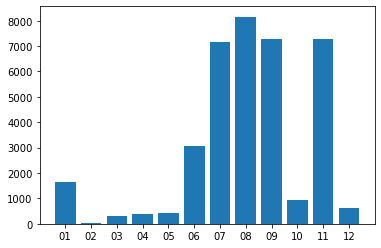

In [47]:
import matplotlib.pyplot as plt
dic = {
    '01' : 1656,
    '02' : 32,
    '03' : 314,
    '04' : 387,
    '05' : 429,
    '06' : 3069,
    '07' : 7170,
    '08' : 8158,
    '09' : 7267,
    '10' : 941,
    '11' : 7262,
    '12' : 625
}
keys = dic.keys()
values = dic.values()
plt.bar(keys, values)

In [93]:
res = []
for e in list_output:
    centroid = e.get_centroid('/media/wenger/DATA2/dataset_v1/ground_reference')
    p = (centroid[0], centroid[1], e.tile)
    res.append(p)

Patch.create_points_shapefile(res, './1_S2_7_8_9_11.shp', epsg='EPSG:4326')

In [166]:
monthes = ['202007', '202008', '202009', '202011']
res = []
for e in list_patches:
    if e.has_days_gap_s2(monthes, date_format='%Y%m', days_gap=15)[1]:
        '''centroid = e.get_centroid('/media/wenger/DATA2/dataset_v1/ground_reference')
        p = (centroid[0], centroid[1], e.tile)
        res.append(p)'''

#Patch.create_points_shapefile(res, './15_days_gap_7_8_9_11.shp', epsg='EPSG:4326')